# Ajuste del modelo exponencial a los datos de erradicación de cabra utilizando pymc

Se intenta determinar el tamaño de la población a partir del número de blancos en función del esfuerzo utilizado utilizando estad+istica bayesiana.

Se cree que el modelo que describe los blancos acumulados en función del esfuerzo es una función de distribucón acumulativa exponencial que tiene la forma

$$F(\mbox{esfuerzo})=N(1-e^{-(\mbox{esfuerzo}-\mbox{loc}) \cdot s^{-1}})$$

donde $N$ representa el tamaño de la población inicial.

**Nota:**
Para poder correr el ejemplo es necesario tener instalado ´pymc3´ el cual se puede instalar utilizando el comando ´conda install pymc3´. También es necesario agregar la variable de entorno ´MKL_THREADING_LAYER´ con el valor ´GNU´, una vez que se agrega esta variable se debe reiniciar la computadora.

In [1]:
%matplotlib inline
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import math
import theano.tensor as tt

Se utilizan datos de la erradicación de cabras en Isla Guadalupe y se consideró a las horas de vuelo como el esfuerzo

In [2]:
esfuerzo = np.array([2.0,4.2,6.2,8.4,9.8,11.8,13.9,15.9,16.9,18.7,21.0,23.2,24.8,26.6,29.2,29.5,31.1,31.9,33.3,34.6,36.3,37.6,
            39.5,40.5,41.5,43.1,44.1,45.0,46.3,47.4,49.3,51.1])
blancos = np.array([328,432,232,303,297,306,196,225,53,209,228,103,125,99,105,19,60,78,153,104,63,37,59,33,66,44,8,5,53,32,33,8])
blancos_acumulados = blancos.cumsum()

Como primera aproximación se escoge que $loc$, $s$ y $N$ tengan una distribución normal.

In [ ]:
esfuerzo_no_acumulado = np.gradient(esfuerzo)
esfuerzo_no_acumulado

## Utilizando todos los datos

In [3]:
def calculateSizePoblation(blancos_acumulados, esfuerzo):
    with pm.Model() as modeloPoblacion:
        alpha = 1.0/blancos_acumulados.mean()
        loc = pm.Normal("loc", mu=alpha, sd = 20)
        s = pm.Normal("s", mu=alpha, sd = 20)
        N = pm.Normal("N", mu=blancos_acumulados.max(), sd = 20)
        F = pm.Deterministic("F", N*(1 - tt.exp(-(esfuerzo-loc)/s)))
        valoresObservados = pm.Normal("valores_observados", F, observed=blancos_acumulados)
        start = pm.find_MAP()
        step = pm.Metropolis()
        trace = pm.sample(6000, step=step, start=start)
    return trace[3000:]

In [4]:
burnOut = calculateSizePoblation(blancos_acumulados, esfuerzo)

logp = -3.7474e+07, ||grad|| = 35,321: 100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 1139.99it/s]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [N]
>Metropolis: [s]
>Metropolis: [loc]
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
with modeloPoblacion:
    valoresObservados = pm.Normal("valores_observados", F, observed=blancos_acumulados)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(6000, step=step, start=start)

Se sugiere descartar la primera mitad de las muestras ya que usualmente solo son ruido.

In [ ]:
N


In [ ]:
burnOut = trace[3000:]

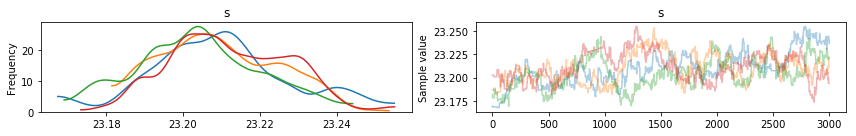

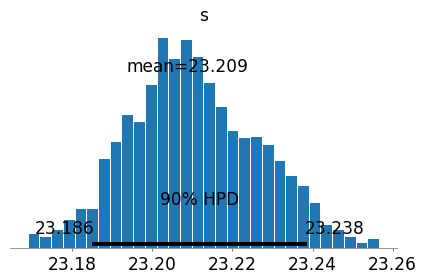

In [5]:
pm.plots.traceplot(trace=burnOut, varnames=["s"])
pm.plots.plot_posterior(trace=burnOut, varnames=["s"], alpha_level=0.1, text_size=17)

## Tamaño inicial de la población
El distribución posterior del tamaño inical de la población la mostramos en la siguiente figura

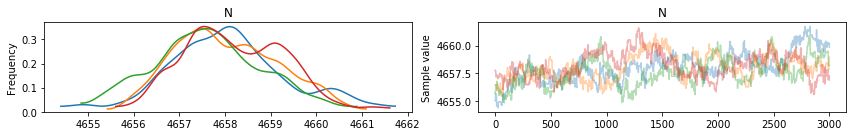

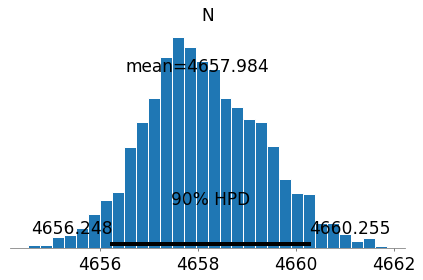

In [6]:
pm.plots.traceplot(trace=burnOut, varnames=["N"])
pm.plots.plot_posterior(trace=burnOut, varnames=["N"], alpha_level=0.1, text_size=17)

El intervalo de confianza del 95% del tamaño inical de la población es

In [ ]:
IC = np.percentile(burnOut["N"][:],[2.5,97.5])
IC

La cantidad de gatos que nos falta retirar para lograr una disminución del 99% del máximo de la población

In [ ]:
gatosRestantes = math.ceil(IC[-1] * .99 - blancos_acumulados[-1])
gatosRestantes

## Los parámetros `loc` y `s`

In [ ]:
pm.plots.traceplot(trace=burnOut, varnames=["loc"])
pm.plots.plot_posterior(trace=burnOut, varnames=["loc"], alpha_level=0.1, text_size=17)

In [ ]:
## El modelo
El modelo utilizando 

In [ ]:
loc_probable = burnOut.get_values('loc').mean()
s_probable = burnOut.get_values('s').mean()
N_probable = burnOut.get_values('N').mean()

In [ ]:
y = N_probable*(1-np.exp(-(esfuerzo-loc_probable) /s_probable))

In [ ]:
plt.plot(esfuerzo, y)
plt.scatter(esfuerzo,blancos_acumulados)

Utilizando este modelo se tiene que el valor aproximado de la población inicial es de $4\,397$ Cabras, el valor real es de $4\,096$.

## Captura por unidad de esfuerzo

In [ ]:
y = N_probable*(np.exp(-(esfuerzo-loc_probable) /s_probable))/s_probable

In [ ]:
plt.plot(esfuerzo, y)
plt.scatter(esfuerzo,blancos/esfuerzo_no_acumulado)

## Esfuerzo necesario
El esfuerzo necesario para terminar la erradicación será $$\mbox{esfuerzo} = \mbox{loc} - s*\log{0.5}$$

In [ ]:
esfuerzo_requerido = math.ceil(loc_probable - s_probable * math.log(0.05))
esfuerzo_requerido

Así que el esfuerzo que nos falta es

In [ ]:
esfuerzoFaltante = math.ceil(esfuerzo_requerido - esfuerzo[-1])
esfuerzoFaltante

## Utilizando la mitad de los datos

In [ ]:
esMitadDatos = blancos_acumulados.shape[0]//2

In [ ]:
with pm.Model() as modeloPoblacionMitadDatos:
    alpha = 1.0/blancos_acumulados[:esMitadDatos].mean()
    loc = pm.Normal("loc", mu=alpha)
    s = pm.Normal("s", mu=alpha)
    N = pm.Normal("N", mu=blancos_acumulados.max())
    F = pm.Deterministic("F", N*(1 - tt.exp(-(esfuerzo[:esMitadDatos]-loc)/s)))

In [ ]:
with modeloPoblacionMitadDatos:
    valoresObservados = pm.Normal("valores_observados", F, observed=blancos_acumulados[:esMitadDatos])
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(6000, step=step, start=start)

In [ ]:
# Se quitan los primeros datos
burnOut = trace[3000:]

In [ ]:
pm.plots.traceplot(trace=burnOut, varnames=["s"])
pm.plots.plot_posterior(trace=burnOut, varnames=["s"], alpha_level=0.1, text_size=17)

In [ ]:
pm.plots.traceplot(trace=burnOut, varnames=["N"])
pm.plots.plot_posterior(trace=burnOut, varnames=["N"], alpha_level=0.1, text_size=17)

In [ ]:
pm.plots.traceplot(trace=burnOut, varnames=["loc"])
pm.plots.plot_posterior(trace=burnOut, varnames=["loc"], alpha_level=0.1, text_size=17)

In [ ]:
loc_probable = burnOut.get_values('loc').mean()
s_probable = burnOut.get_values('s').mean()
N_probable = burnOut.get_values('N').mean()

In [ ]:
y = N_probable*(1-np.exp(-(esfuerzo-loc_probable) /s_probable))

In [ ]:
plt.plot(esfuerzo, y)
plt.scatter(esfuerzo,blancos_acumulados)
# Estos son los datos con los que se creó el modelo
plt.scatter(esfuerzo[:esMitadDatos],blancos_acumulados[:esMitadDatos])

Según este modelo el tamaño inicial de la población es de 4120, el real es de 4096